In [35]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# German tank problem
In the statistical theory of estimation, the German tank problem consists of estimating the maximum of a discrete uniform distribution from sampling without replacement. In simple terms, suppose we have an unknown number of items which are sequentially numbered from 1 to N. We take a random sample of these items and observe their sequence numbers; the problem is to estimate N from these observed numbers. For tank proof see [here](https://laurentlessard.com/bookproofs/tank-counting/).

In [82]:
num_tanks = 1000
num_captured = 15
num_simulations = 100_000
def generate_sample(): return np.random.randint(1, num_tanks+1, num_captured)

In [91]:
def plot(simulations):
    mean = np.mean(simulations)
    plt.plot([mean, mean], [0, 0.011], '--r')
    _ = plt.hist(simulations, density=True)
    print(f"mean is {mean: .2f}, std is {np.std(simulations):.2f}")

## 0. Naive way
Use the maximum serial number as the total number.

mean is  937.86, std is 58.76


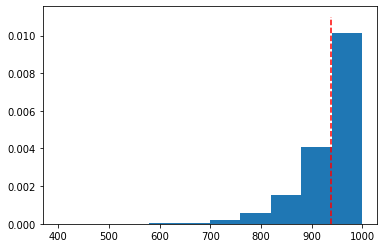

In [92]:
simulations = [np.max(generate_sample()) for _ in range(num_simulations)]
plot(simulations)

## 1. Frequentist inference
Let $m$ be the maximum serial number and $k$ be the number of observed tanks, 
$$N \approx m+\frac{m}{k}-1$$
We can understand this in the following way, since serial numbers are generated uniformly, so the space between serial numbers should be small. The average spacing between serial number is $m/(k)-1$. We just conpensate this to $m$.

mean is  999.57, std is 62.43


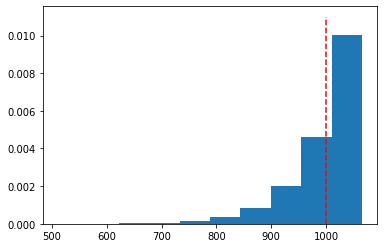

In [93]:
# define a compensate estimator
def compensate(observed):
    m = np.max(observed)
    spacing = m*1./num_captured - 1
    return m + spacing
simulations = [compensate(generate_sample()) for _ in range(num_simulations)]
plot(simulations)

## Bayesian analysis

Conditional probability:
\begin{aligned}
    P(A_1,\dots, A_n) &= P(A_2,\dots, A_n|A_1)P(A_1)\\
                      &=P(A_3,\dots, A_n|A_1,A_2)P(A_2|A_1)P(A_1)\\
                      &=P(A_4,\dots, A_n|A_1,A_2)P(A_3|A_1, A_2)P(A_2|A_1)P(A_1)\\
                      &=\cdots
\end{aligned}

The Bayesian approach to the German tank problem is to consider the credibility  $(N=n | M=m, K=k)$. The conditional probability gives us 
$$(n | m, k)(m | k)=(m | n, k)(n | k)=(m, n | k)$$
Then we have 
$$(n | m, k) =(m | n, k)(n | k)(m | k)^{-1} =(m, n | k)(m | k)^{-1}$$

### 1. Probability of $M$ knowing $N$ and $K$.
Select from $n$ tanks $m-1$ tanks, the pick the largest one.
$$(m | n, k)=\left(\begin{array}{c}{m-1} \\ {k-1}\end{array}\right)\left(\begin{array}{l}{n} \\ {k}\end{array}\right)^{-1}$$

### 2. Probability of $M$ knowing only $K$
\begin{aligned}(m | k) &=(m | k) \cdot 1 =(m | k) \sum_{n=0}^{\infty}(n | m, k) =(m | k) \sum_{n=0}^{\infty}(m | n, k) \frac{(n | k)}{(m | k)}=\sum_{n=0}^{\infty}(m | n, k)(n | k) 
\end{aligned}
### 3. Credibility of $N$ knowing only $K$
Let $\Omega$ be the real maximum serial number.
$$(n|k)=(\Omega-k)^{-1}$$
### 4. Sum up together
\begin{aligned}
    (n | m, k) &= (m | n, k)(n | k)(m | k)^{-1}\\
               &=(m|n,k)\left(\sum_{n=m}^{\infty}(m | n, k)(n | k)\right)^{-1}
\end{aligned}
The pmf is 
$$\operatorname{Pr}(N=n)=\left\{\begin{array}{ll}{0} & {\text { if } n<m} \\ {\frac{k-1}{k} \frac{\left(\begin{array}{c}{m-1} \\ {k-1}\end{array}\right)}{\left(\begin{array}{c}{n} \\ {k}\end{array}\right)}}\approx (k-1) m^{k-1} n^{-k} & {\text { if } n \geq m}\end{array}\right.$$
the mean and variance is 
\begin{array}{l}{\mu=(m-1) \frac{k-1}{k-2}} \\ {\sigma=\sqrt{\frac{(k-1)(m-1)(m-k+1)}{(k-3)(k-2)^{2}}}}\end{array}

In [95]:
def bayes_mean(observed):
    m = np.max(observed)
    k = len(observed)
    return (m-1)*(k-1)*1./(k-2)
simulations = [bayes_mean(generate_sample()) for _ in range(num_simulations)]

mean is  1009.14, std is 62.93


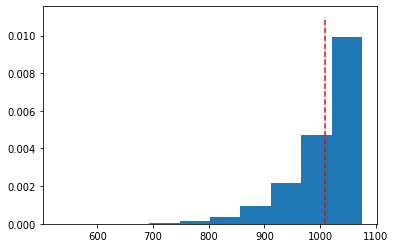

In [96]:
plot(simulations)

### Probabilistic programming using PyMC3
Instead of setting a fixed value for the total number of tanks, with probabilistic programming, we define a prior distribution that encodes our apriori beliefs and knowledge about the parameter(s) of interest. In this case, a reasonable prior distribution for the number of tanks is a DiscreteUniform2 with a lower bound at the maximum serial number of the captured tanks (since it’s impossible for the number of tanks to be lower than this), and an upper bound at some sufficiently large number, say 2000.

In [108]:
import pymc3 as pm
captured = [499, 505, 190, 427, 185, 572, 818, 721, 
            912, 302, 765, 231, 547, 410, 884]

In [109]:
with pm.Model():
    num_tanks = pm.DiscreteUniform(
        "num_tanks", 
        lower=max(captured), 
        upper=2000
    )
    likelihood = pm.DiscreteUniform(
        "observed", 
        lower=1, 
        upper=num_tanks, 
        observed=num_captured
    )
    posterior = pm.sample(10000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [num_tanks]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:04<00:00, 9273.68draws/s] 
The number of effective samples is smaller than 25% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f563d077b38>],
      dtype=object)

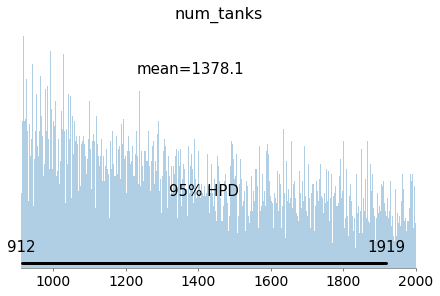

In [110]:
pm.plot_posterior(posterior, credible_interval=0.95)

### Probabilistic programming using Pyro

In [197]:
import pyro
import torch

import math
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints

from scipy.stats import bernoulli, beta
from pyro import plate
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

### Sample from posterior distribution

In [225]:
data = bernoulli(0.8).rvs(1000)
data = torch.from_numpy(data).float()
num_tail, num_heads= np.bincount(data)
num_tail, num_heads

(202, 798)

In [226]:
def model(data):
    p = pyro.sample("latent_fairness", dist.Beta(10., 10.))
    with plate('observed'): 
        pyro.sample("obs", dist.Bernoulli(p), obs=data)
        
def guide(data):
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [231]:
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 1000
# do gradient steps
for step in range(n_steps): 
    svi.step(data)

In [232]:
alpha_q = pyro.param('alpha_q').item()
beta_q = pyro.param('beta_q').item()
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.793 +- 0.028


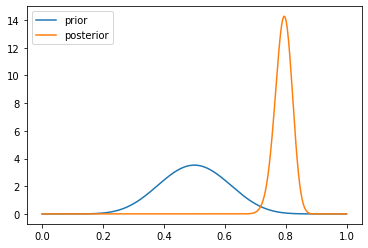

In [235]:
x = np.linspace(0, 1, 500)
prior = beta(10, 10).pdf(x)
posterior = beta(alpha_q, beta_q).pdf(x)
plt.plot(x, prior, label='prior')
plt.plot(x, posterior, label='posterior')
plt.legend()

### Try German tank problem

In [155]:
def model():
    # the prior is p(n) = 1/(high-low)
    num_tanks = pyro.sample("num_tanks", dist.Uniform(low=max(captured), high=2000))
    return pyro.sample("num_")

In [119]:
for _ in range(10):
    print(model())

1133
1854
1960
1645
939
971
1788
1630
1287
1965
